In [10]:
!pip -q install soundfile
!apt-get -qq update
!apt-get -qq install -y libsndfile1


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [1]:
!pip -q install torch torchaudio transformers accelerate pandas numpy tqdm gradio soundfile smplx trimesh pygltflib huggingface_hub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.0/737.0 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.2 MB/s eta 0:00:00


In [2]:
from google.colab import files
uploaded = files.upload()  # upload ecolang.csv


Saving ecolang.csv to ecolang.csv


In [3]:
import pandas as pd

CSV_PATH = "ecolang.csv"
df = pd.read_csv(CSV_PATH)
print(df.shape)
display(df.head())
print(df.columns.tolist())
print(df["split"].value_counts())


(39, 7)


,id,split,audio_path,motion_path,start_frame,end_frame,speaker
0,ch08_speakerview_001,train,/content/drive/MyDrive/Extracted_Parameters/ch...,/content/drive/MyDrive/Extracted_Parameters/SE...,0,1800,ch08_speakerview
1,ch08_speakerview_002,train,/content/drive/MyDrive/Extracted_Parameters/ch...,/content/drive/MyDrive/Extracted_Parameters/SE...,1800,3600,ch08_speakerview
2,ch08_speakerview_003,train,/content/drive/MyDrive/Extracted_Parameters/ch...,/content/drive/MyDrive/Extracted_Parameters/SE...,3600,5400,ch08_speakerview
3,ch08_speakerview_004,train,/content/drive/MyDrive/Extracted_Parameters/ch...,/content/drive/MyDrive/Extracted_Parameters/SE...,5400,7200,ch08_speakerview
4,ch08_speakerview_005,train,/content/drive/MyDrive/Extracted_Parameters/ch...,/content/drive/MyDrive/Extracted_Parameters/SE...,7200,9000,ch08_speakerview


['id', 'split', 'audio_path', 'motion_path', 'start_frame', 'end_frame', 'speaker']
split
train    39
Name: count, dtype: int64


In [4]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd

CSV_PATH = "ecolang.csv"
df = pd.read_csv(CSV_PATH)

p = df.loc[0, "motion_path"]
z = np.load(p, allow_pickle=True)

print("motion_path:", p)
print("keys:", list(z.keys()))

for k in z.keys():
    arr = z[k]
    if hasattr(arr, "shape"):
        print(f"{k:12s} shape={arr.shape} dtype={arr.dtype}")
        if arr.ndim <= 2:
            print("  first row:", arr[0] if arr.ndim > 0 else arr)
    else:
        print(k, type(arr))

# print fps value
if "fps" in z:
    print("fps value:", z["fps"])

# show min/max for first frame of poses/expressions
if "poses" in z:
    a = z["poses"]
    print("poses[0] min/max:", float(a[0].min()), float(a[0].max()))
if "expressions" in z:
    e = z["expressions"]
    print("expressions[0] min/max:", float(e[0].min()), float(e[0].max()))


motion_path: /content/drive/MyDrive/Extracted_Parameters/SEQ_OUT/ch08_speakerview_001_parameters.npz
keys: ['poses', 'expressions', 'betas', 'transl', 'fps']
poses        shape=(1801, 55, 3) dtype=float32
expressions  shape=(1801, 10) dtype=float32
  first row: [ 0.7056468  -0.09641305 -1.1688848   0.03640318  0.41900083 -0.63858134
 -0.51649404  0.22494973 -0.35724327 -0.18140075]
betas        shape=(10,) dtype=float32
  first row: -0.03564915
transl       shape=(1801, 3) dtype=float32
  first row: [2.9646235e-03 7.9617774e-01 1.5090468e+01]
fps          shape=() dtype=int32
  first row: 30
fps value: 30
poses[0] min/max: -3.132460594177246 1.0621380805969238
expressions[0] min/max: -1.1688847541809082 0.705646812915802


In [6]:
FPS = 30
WIN_SEC = 4.0
WIN_FRAMES = int(FPS * WIN_SEC)

SR = 16000
WIN_SAMPLES = int(SR * WIN_SEC)

JAW_INDEX = 22          # standard SMPL-X packing
EXPR_DIM = 10


In [11]:
import soundfile as sf
import numpy as np
import torch

def _resample_np(wav, orig_sr, target_sr):
    if orig_sr == target_sr:
        return wav
    x_old = np.linspace(0, 1, num=len(wav), endpoint=False)
    new_len = int(len(wav) * target_sr / orig_sr)
    x_new = np.linspace(0, 1, num=new_len, endpoint=False)
    return np.interp(x_new, x_old, wav).astype(np.float32)

class EcolangFaceDataset(Dataset):
    def __init__(self, df, split="train"):
        self.df = df[df["split"] == split].reset_index(drop=True)
        self.split = split

    def __len__(self):
        return len(self.df)

    def _load_audio_segment(self, audio_path, t0_sec):
        wav, sr = sf.read(audio_path, always_2d=False)  # wav: (N,) or (N,C)
        if wav.ndim == 2:
            wav = wav.mean(axis=1)  # to mono

        wav = wav.astype(np.float32)
        wav = _resample_np(wav, sr, SR)

        start = int(t0_sec * SR)
        end = start + WIN_SAMPLES

        if start < 0:
            start = 0
            end = WIN_SAMPLES

        if end > wav.shape[0]:
            pad = end - wav.shape[0]
            wav = np.pad(wav, (0, pad), mode="constant")

        seg = wav[start:end]
        return torch.from_numpy(seg)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_path = str(row["audio_path"])
        motion_path = str(row["motion_path"])
        start_f = int(row["start_frame"])
        end_f = int(row["end_frame"])

        z = np.load(motion_path, allow_pickle=True)
        poses = z["poses"].astype(np.float32)
        expr  = z["expressions"].astype(np.float32)

        seg_len = end_f - start_f
        if seg_len < WIN_FRAMES:
            win_start = start_f
        else:
            if self.split == "train":
                win_start = start_f + np.random.randint(0, seg_len - WIN_FRAMES + 1)
            else:
                win_start = start_f + (seg_len - WIN_FRAMES) // 2

        win_end = win_start + WIN_FRAMES

        jaw = poses[win_start:win_end, JAW_INDEX, :]
        ex  = expr[win_start:win_end, :]

        if jaw.shape[0] != WIN_FRAMES:
            pad = WIN_FRAMES - jaw.shape[0]
            jaw = np.concatenate([jaw, np.zeros((pad,3), np.float32)], axis=0)
            ex  = np.concatenate([ex,  np.zeros((pad,EXPR_DIM), np.float32)], axis=0)

        y = np.concatenate([jaw, ex], axis=1)
        y = torch.from_numpy(y)

        t0_sec = (win_start - start_f) / FPS
        x = self._load_audio_segment(audio_path, t0_sec)

        return {"x": x, "y": y}


In [7]:
import numpy as np
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader

class EcolangFaceDataset(Dataset):
    def __init__(self, df, split="train"):
        self.df = df[df["split"] == split].reset_index(drop=True)
        self.split = split
        self._resampler = None

    def __len__(self):
        return len(self.df)

    def _load_audio_segment(self, audio_path, t0_sec):
        wav, sr = torchaudio.load(audio_path)
        wav = wav.mean(dim=0)

        if sr != SR:
            if self._resampler is None:
                self._resampler = torchaudio.transforms.Resample(sr, SR)
            wav = self._resampler(wav.unsqueeze(0)).squeeze(0)

        start = int(t0_sec * SR)
        end = start + WIN_SAMPLES

        if start < 0:
            start = 0
            end = WIN_SAMPLES

        if end > wav.numel():
            wav = torch.nn.functional.pad(wav, (0, end - wav.numel()))
        return wav[start:end]  # (WIN_SAMPLES,)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_path = str(row["audio_path"])
        motion_path = str(row["motion_path"])
        start_f = int(row["start_frame"])
        end_f = int(row["end_frame"])

        z = np.load(motion_path, allow_pickle=True)
        poses = z["poses"].astype(np.float32)
        expr  = z["expressions"].astype(np.float32)

        seg_len = end_f - start_f
        if seg_len < WIN_FRAMES:
            win_start = start_f
        else:
            if self.split == "train":
                win_start = start_f + np.random.randint(0, seg_len - WIN_FRAMES + 1)
            else:
                win_start = start_f + (seg_len - WIN_FRAMES) // 2

        win_end = win_start + WIN_FRAMES

        jaw = poses[win_start:win_end, JAW_INDEX, :]
        ex  = expr[win_start:win_end, :]

        if jaw.shape[0] != WIN_FRAMES:
            pad = WIN_FRAMES - jaw.shape[0]
            jaw = np.concatenate([jaw, np.zeros((pad,3), np.float32)], axis=0)
            ex  = np.concatenate([ex,  np.zeros((pad,EXPR_DIM), np.float32)], axis=0)

        y = np.concatenate([jaw, ex], axis=1)
        y = torch.from_numpy(y)

        t0_sec = (win_start - start_f) / FPS
        x = self._load_audio_segment(audio_path, t0_sec)

        return {"x": x, "y": y}

def collate(batch):
    x = torch.stack([b["x"] for b in batch], dim=0)
    y = torch.stack([b["y"] for b in batch], dim=0)
    return {"x": x, "y": y}


In [8]:
import torch
import torch.nn as nn
from transformers import Wav2Vec2Model

OUT_DIM = 3 + EXPR_DIM  # 13

class Audio2Face(nn.Module):
    def __init__(self, out_dim=OUT_DIM, freeze_w2v=True, w2v_name="facebook/wav2vec2-base", hidden=256, layers=2):
        super().__init__()
        self.w2v = Wav2Vec2Model.from_pretrained(w2v_name)
        feat = self.w2v.config.hidden_size

        if freeze_w2v:
            for p in self.w2v.parameters():
                p.requires_grad = False

        self.proj = nn.Linear(feat, hidden)
        self.lstm = nn.LSTM(hidden, hidden, num_layers=layers, batch_first=True, bidirectional=True)
        self.head = nn.Sequential(nn.LayerNorm(hidden*2), nn.Linear(hidden*2, out_dim))

    def forward(self, x):
        h = self.w2v(x).last_hidden_state
        h = self.proj(h)

        h = h.transpose(1,2)
        h = torch.nn.functional.interpolate(h, size=WIN_FRAMES, mode="linear", align_corners=False)
        h = h.transpose(1,2)

        h, _ = self.lstm(h)
        yhat = self.head(h)
        return yhat


In [12]:
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

train_ds = EcolangFaceDataset(df, "train")
val_split = "val" if (df["split"] == "val").any() else "train"
val_ds   = EcolangFaceDataset(df, val_split)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0, collate_fn=collate)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=0, collate_fn=collate)

model = Audio2Face(out_dim=OUT_DIM, freeze_w2v=True).to(device)
opt = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=3e-4)
loss_fn = torch.nn.L1Loss()

EPOCHS = 25
best = 1e9

for epoch in range(1, EPOCHS+1):
    model.train()
    tr = 0.0
    for batch in tqdm(train_loader, desc=f"train {epoch}"):
        x = batch["x"].to(device)
        y = batch["y"].to(device)
        yhat = model(x)
        loss = loss_fn(yhat, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        tr += loss.item()
    tr /= max(1, len(train_loader))

    model.eval()
    va = 0.0
    with torch.no_grad():
        for batch in val_loader:
            x = batch["x"].to(device)
            y = batch["y"].to(device)
            yhat = model(x)
            va += loss_fn(yhat, y).item()
    va /= max(1, len(val_loader))

    print(f"epoch {epoch}: train={tr:.4f} val={va:.4f}")

    if va < best:
        best = va
        torch.save({"model": model.state_dict()}, "best_face.pt")
        print("saved best_face.pt")


device: cuda


train 1: 100%|██████████| 5/5 [00:53<00:00, 10.66s/it]


epoch 1: train=0.3775 val=0.2661
saved best_face.pt


train 2: 100%|██████████| 5/5 [00:17<00:00,  3.54s/it]


epoch 2: train=0.2043 val=0.1783
saved best_face.pt


train 3: 100%|██████████| 5/5 [00:17<00:00,  3.50s/it]


epoch 3: train=0.1375 val=0.1465
saved best_face.pt


train 4: 100%|██████████| 5/5 [00:18<00:00,  3.65s/it]


epoch 4: train=0.1108 val=0.0804
saved best_face.pt


train 5: 100%|██████████| 5/5 [00:17<00:00,  3.45s/it]


epoch 5: train=0.0875 val=0.0588
saved best_face.pt


train 6: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]


epoch 6: train=0.0723 val=0.0655


train 7: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]


epoch 7: train=0.0649 val=0.0649


train 8: 100%|██████████| 5/5 [00:16<00:00,  3.40s/it]


epoch 8: train=0.0583 val=0.0398
saved best_face.pt


train 9: 100%|██████████| 5/5 [00:17<00:00,  3.46s/it]


epoch 9: train=0.0478 val=0.0482


train 10: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]


epoch 10: train=0.0438 val=0.0499


train 11: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]


epoch 11: train=0.0409 val=0.0377
saved best_face.pt


train 12: 100%|██████████| 5/5 [00:17<00:00,  3.42s/it]


epoch 12: train=0.0382 val=0.0366
saved best_face.pt


train 13: 100%|██████████| 5/5 [00:17<00:00,  3.56s/it]


epoch 13: train=0.0350 val=0.0308
saved best_face.pt


train 14: 100%|██████████| 5/5 [00:17<00:00,  3.46s/it]


epoch 14: train=0.0330 val=0.0392


train 15: 100%|██████████| 5/5 [00:17<00:00,  3.55s/it]


epoch 15: train=0.0330 val=0.0285
saved best_face.pt


train 16: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]


epoch 16: train=0.0293 val=0.0266
saved best_face.pt


train 17: 100%|██████████| 5/5 [00:17<00:00,  3.52s/it]


epoch 17: train=0.0291 val=0.0256
saved best_face.pt


train 18: 100%|██████████| 5/5 [00:17<00:00,  3.52s/it]


epoch 18: train=0.0284 val=0.0304


train 19: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]


epoch 19: train=0.0276 val=0.0276


train 20: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]


epoch 20: train=0.0288 val=0.0301


train 21: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]


epoch 21: train=0.0276 val=0.0202
saved best_face.pt


train 22: 100%|██████████| 5/5 [00:17<00:00,  3.46s/it]


epoch 22: train=0.0265 val=0.0273


train 23: 100%|██████████| 5/5 [00:16<00:00,  3.35s/it]


epoch 23: train=0.0329 val=0.0257


train 24: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]


epoch 24: train=0.0269 val=0.0261


train 25: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]


epoch 25: train=0.0285 val=0.0271


In [13]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt = torch.load("best_face.pt", map_location="cpu")
model.load_state_dict(ckpt["model"], strict=True)
model.to(device).eval()
print("loaded best_face.pt")


loaded best_face.pt


In [14]:
sample = train_ds[0]
x = sample["x"].unsqueeze(0).to(device)

with torch.no_grad():
    yhat = model(x)[0].cpu()

print("yhat shape:", yhat.shape)
print("jaw first frame:", yhat[0, :3])
print("expr first frame:", yhat[0, 3:8])


yhat shape: torch.Size([120, 13])
jaw first frame: tensor([0.0297, 0.0087, 0.0021])
expr first frame: tensor([-0.0388,  0.0281, -0.0458, -0.1570,  0.0106])


In [15]:
import soundfile as sf
import numpy as np
import torch

def _resample_np(wav, orig_sr, target_sr):
    if orig_sr == target_sr:
        return wav
    x_old = np.linspace(0, 1, num=len(wav), endpoint=False)
    new_len = int(len(wav) * target_sr / orig_sr)
    x_new = np.linspace(0, 1, num=new_len, endpoint=False)
    return np.interp(x_new, x_old, wav).astype(np.float32)

def predict_jaw_expr_from_audio(audio_path):
    wav, sr = sf.read(audio_path, always_2d=False)
    if wav.ndim == 2:
        wav = wav.mean(axis=1)
    wav = wav.astype(np.float32)
    wav = _resample_np(wav, sr, SR)

    if len(wav) < WIN_SAMPLES:
        wav = np.pad(wav, (0, WIN_SAMPLES - len(wav)), mode="constant")
    wav = wav[:WIN_SAMPLES]

    x = torch.from_numpy(wav).unsqueeze(0).to(device)

    with torch.no_grad():
        yhat = model(x)[0].cpu().numpy()

    jaw = yhat[:, :3]
    expr = yhat[:, 3:]
    return jaw, expr


In [29]:
import smplx, trimesh, torch

SMPLX_MODEL_DIR = "/content/drive/MyDrive/OSXBackup/OSX/common/utils/human_model_files"

layer = smplx.create(
    SMPLX_MODEL_DIR, model_type="smplx", gender="neutral", use_pca=False, batch_size=1,
    create_global_orient=True, create_body_pose=True, create_betas=True, create_expression=True,
    create_jaw_pose=True, create_left_hand_pose=True, create_right_hand_pose=True
).to(device).eval()

def export_glb_from_pred(jaw_seq, expr_seq, betas=None, out_path="pred_face.glb"):
    mid = jaw_seq.shape[0] // 2

    jaw = torch.tensor(jaw_seq[mid], dtype=torch.float32, device=device).view(1,3)
    expr = torch.tensor(expr_seq[mid], dtype=torch.float32, device=device).view(1,EXPR_DIM)

    if betas is None:
        betas = torch.zeros((1,10), device=device)
    else:
        betas = torch.tensor(betas, dtype=torch.float32, device=device).view(1,10)

    zeros3 = torch.zeros((1,3), device=device)
    zeros63 = torch.zeros((1,63), device=device)
    zeros45 = torch.zeros((1,45), device=device)

    with torch.no_grad():
        out = layer(
            global_orient=zeros3,
            body_pose=zeros63,
            left_hand_pose=zeros45,
            right_hand_pose=zeros45,
            jaw_pose=jaw,
            expression=expr,
            betas=betas
        )
    v = out.vertices[0].detach().cpu().numpy()
    mesh = trimesh.Trimesh(vertices=v, faces=layer.faces, process=False)
    mesh.export(out_path)
    return out_path


In [30]:
row = df[df["split"]=="train"].iloc[0]
jaw_pred, expr_pred = predict_jaw_expr_from_audio(row["audio_path"])

z = np.load(row["motion_path"], allow_pickle=True)
betas = z["betas"]

out_path = export_glb_from_pred(jaw_pred, expr_pred, betas=betas, out_path="pred_face.glb")
out_path


'pred_face.glb'

In [31]:
from google.colab import files
files.download("pred_face.glb")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
import os, shutil
BUNDLE_DIR = "hf_space_bundle"
os.makedirs(BUNDLE_DIR, exist_ok=True)

shutil.copy("best_face.pt", os.path.join(BUNDLE_DIR, "best_face.pt"))
print("Copied best_face.pt to", BUNDLE_DIR)


Copied best_face.pt to hf_space_bundle


In [40]:
req = """torch
transformers
soundfile
numpy
gradio>=4.0
matplotlib
"""
with open(os.path.join(BUNDLE_DIR, "requirements.txt"), "w") as f:
    f.write(req)

print("Wrote requirements.txt")


Wrote requirements.txt


In [41]:
app_py = r'''
import os
import zipfile
import tempfile
import numpy as np
import gradio as gr
import soundfile as sf
import torch
import torch.nn as nn
from transformers import Wav2Vec2Model
import matplotlib.pyplot as plt

# ---------------- constants ----------------
FPS = 30
SR = 16000
WIN_SEC = 4.0
WIN_FRAMES = int(FPS * WIN_SEC)
WIN_SAMPLES = int(SR * WIN_SEC)

JAW_INDEX = 22
EXPR_DIM = 10
OUT_DIM = 3 + EXPR_DIM

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- utils ----------------
def _resample_np(wav, orig_sr, target_sr):
    if orig_sr == target_sr:
        return wav
    x_old = np.linspace(0, 1, num=len(wav), endpoint=False)
    new_len = int(len(wav) * target_sr / orig_sr)
    x_new = np.linspace(0, 1, num=new_len, endpoint=False)
    return np.interp(x_new, x_old, wav).astype(np.float32)

def load_audio_mono(audio_path):
    wav, sr = sf.read(audio_path, always_2d=False)
    if wav.ndim == 2:
        wav = wav.mean(axis=1)
    wav = wav.astype(np.float32)
    wav = _resample_np(wav, sr, SR)
    return wav

# ---------------- model ----------------
class Audio2Face(nn.Module):
    def __init__(self, out_dim=OUT_DIM, w2v_name="facebook/wav2vec2-base", hidden=256, layers=2):
        super().__init__()
        self.w2v = Wav2Vec2Model.from_pretrained(w2v_name)
        feat = self.w2v.config.hidden_size
        self.proj = nn.Linear(feat, hidden)
        self.lstm = nn.LSTM(hidden, hidden, num_layers=layers, batch_first=True, bidirectional=True)
        self.head = nn.Sequential(nn.LayerNorm(hidden*2), nn.Linear(hidden*2, out_dim))

    def forward(self, x):
        h = self.w2v(x).last_hidden_state
        h = self.proj(h)
        h = h.transpose(1,2)
        h = torch.nn.functional.interpolate(h, size=WIN_FRAMES, mode="linear", align_corners=False)
        h = h.transpose(1,2)
        h, _ = self.lstm(h)
        return self.head(h)

def load_checkpoint(path="best_face.pt"):
    model = Audio2Face().to(DEVICE).eval()
    ckpt = torch.load(path, map_location="cpu")
    model.load_state_dict(ckpt["model"], strict=True)
    return model

MODEL = load_checkpoint("best_face.pt")

# ---------------- inference: long audio -> stitched motion ----------------
@torch.no_grad()
def predict_full_sequence(wav_np):
    """
    wav_np: float32 mono at 16k, any length
    returns:
      jaw_seq: (T,3)
      expr_seq: (T,10)
      fps: 30
    """
    N = len(wav_np)
    if N == 0:
        return np.zeros((0,3), np.float32), np.zeros((0,EXPR_DIM), np.float32)

    # pad to full windows
    num_windows = int(np.ceil(N / WIN_SAMPLES))
    padded = np.pad(wav_np, (0, num_windows*WIN_SAMPLES - N), mode="constant")

    jaw_all = []
    expr_all = []

    for w in range(num_windows):
        seg = padded[w*WIN_SAMPLES:(w+1)*WIN_SAMPLES]
        x = torch.from_numpy(seg).unsqueeze(0).to(DEVICE)  # (1, WIN_SAMPLES)
        yhat = MODEL(x)[0].detach().cpu().numpy()          # (WIN_FRAMES,13)
        jaw_all.append(yhat[:, :3])
        expr_all.append(yhat[:, 3:])

    jaw = np.concatenate(jaw_all, axis=0)
    expr = np.concatenate(expr_all, axis=0)

    # trim frames to actual audio length
    # expected frames = floor(seconds*FPS)
    seconds = N / SR
    T = int(np.floor(seconds * FPS))
    if T <= 0:
        T = 1
    jaw = jaw[:T]
    expr = expr[:T]
    return jaw.astype(np.float32), expr.astype(np.float32)

def build_motion_npz(jaw, expr, fps=30):
    """
    create a SMPL-X-like npz:
      poses: (T,55,3) only jaw filled
      expressions: (T,10)
      betas: (10,) zeros
      transl: (T,3) zeros
      fps: int
    """
    T = jaw.shape[0]
    poses = np.zeros((T, 55, 3), dtype=np.float32)
    poses[:, JAW_INDEX, :] = jaw

    betas = np.zeros((10,), dtype=np.float32)
    transl = np.zeros((T,3), dtype=np.float32)

    return {
        "poses": poses,
        "expressions": expr.astype(np.float32),
        "betas": betas,
        "transl": transl,
        "fps": np.int32(fps)
    }

def plot_preview(jaw, expr, out_png):
    # simple visualization of motion over time
    t = np.arange(jaw.shape[0]) / FPS
    plt.figure()
    plt.plot(t, jaw[:,0])
    plt.plot(t, jaw[:,1])
    plt.plot(t, jaw[:,2])
    plt.xlabel("time (s)")
    plt.ylabel("jaw axis-angle")
    plt.title("Predicted jaw motion")
    plt.tight_layout()
    plt.savefig(out_png)
    plt.close()

# ---------------- SMPL-X zip check (optional) ----------------
def verify_smplx_zip(zip_path):
    """
    Users upload their own SMPL-X zip. We just verify it contains expected structure.
    Expect: smplx/SMPLX_NEUTRAL.npz (or similar)
    """
    with zipfile.ZipFile(zip_path, "r") as z:
        names = z.namelist()
    has_smplx_folder = any(n.startswith("smplx/") for n in names)
    has_neutral = any("SMPLX_NEUTRAL" in n and n.startswith("smplx/") for n in names)
    return has_smplx_folder and has_neutral, names[:50]

# ---------------- gradio fn ----------------
def run(audio_file, smplx_zip):
    if audio_file is None:
        return None, None, None, "Upload an audio file."

    # optional zip validation (for licensing-friendly demo)
    zip_msg = ""
    if smplx_zip is not None:
        ok, sample_names = verify_smplx_zip(smplx_zip)
        if not ok:
            return None, None, None, "SMPL-X zip doesn't look right. It must contain smplx/SMPLX_NEUTRAL.npz (and friends)."
        zip_msg = "SMPL-X zip looks valid (not used for rendering in this demo)."

    wav = load_audio_mono(audio_file)
    jaw, expr = predict_full_sequence(wav)

    motion = build_motion_npz(jaw, expr, fps=FPS)

    tmpdir = tempfile.mkdtemp()
    npz_path = os.path.join(tmpdir, "motion_pred.npz")
    np.savez(npz_path, **motion)

    png_path = os.path.join(tmpdir, "jaw_plot.png")
    plot_preview(jaw, expr, png_path)

    info = f"Generated {jaw.shape[0]} frames @ {FPS} fps (~{jaw.shape[0]/FPS:.2f}s). {zip_msg}"
    return npz_path, png_path, info, info

demo = gr.Interface(
    fn=run,
    inputs=[
        gr.Audio(type="filepath", label="Upload audio"),
        gr.File(label="(Optional) Upload your SMPL-X model zip (smplx/SMPLX_NEUTRAL.npz etc.)", file_types=[".zip"])
    ],
    outputs=[
        gr.File(label="Download predicted motion (motion_pred.npz)"),
        gr.Image(label="Motion preview plot"),
        gr.Textbox(label="Info"),
        gr.Textbox(label="Status"),
    ],
    title="ECOLANG Audio → Face Motion (SMPL-X jaw+expression)",
    description="This demo predicts a full motion sequence (not single frame): jaw pose + expression over time. It outputs a motion npz compatible with your ECOLANG format. SMPL-X files are not redistributed; users may upload their own zip if needed for local rendering."
)

if __name__ == "__main__":
    demo.launch()
'''
with open(os.path.join(BUNDLE_DIR, "app.py"), "w") as f:
    f.write(app_py)

print("Wrote app.py")


Wrote app.py


In [42]:
import shutil
zip_path = shutil.make_archive(BUNDLE_DIR, "zip", BUNDLE_DIR)
zip_path


'/content/hf_space_bundle.zip'

In [ ]:
/content/drive/MyDrive/Extracted_Parameters/ch08_speakerview_16k.wav

In [ ]:
# pick an audio from your dataset
row = df.iloc[0]
audio_path = row["audio_path"]

# run the same inference path as app.py
import numpy as np, soundfile as sf
wav, sr = sf.read(audio_path, always_2d=False)
if wav.ndim == 2: wav = wav.mean(axis=1)
wav = wav.astype(np.float32)

print("audio secs:", len(wav)/sr)


TESTTTT

In [43]:
LONG_AUDIO_PATH = "/content/drive/MyDrive/Extracted_Parameters/ch08_speakerview_16k.wav"

START_SEC = 300   # e.g. start at 5 min = 300s
DURATION = 20     # seconds


In [44]:
import soundfile as sf
import numpy as np

def load_audio_slice(path, start_sec, duration_sec, target_sr=16000):
    wav, sr = sf.read(path, always_2d=False)
    if wav.ndim == 2:
        wav = wav.mean(axis=1)
    wav = wav.astype(np.float32)

    # resample if needed
    if sr != target_sr:
        x_old = np.linspace(0, 1, num=len(wav), endpoint=False)
        new_len = int(len(wav) * target_sr / sr)
        x_new = np.linspace(0, 1, num=new_len, endpoint=False)
        wav = np.interp(x_new, x_old, wav).astype(np.float32)
        sr = target_sr

    start = int(start_sec * sr)
    end = int((start_sec + duration_sec) * sr)

    assert end <= len(wav), "Slice exceeds audio length"
    return wav[start:end], sr

wav20, sr = load_audio_slice(LONG_AUDIO_PATH, START_SEC, DURATION)
print("slice shape:", wav20.shape, "secs:", len(wav20)/sr)


slice shape: (320000,) secs: 20.0


In [45]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict_full_sequence_from_wav(wav_np):
    N = len(wav_np)
    WIN_SAMPLES = 16000 * 4   # 4s windows
    FPS = 30

    num_windows = int(np.ceil(N / WIN_SAMPLES))
    padded = np.pad(wav_np, (0, num_windows*WIN_SAMPLES - N), mode="constant")

    jaw_all = []
    expr_all = []

    for w in range(num_windows):
        seg = padded[w*WIN_SAMPLES:(w+1)*WIN_SAMPLES]
        x = torch.from_numpy(seg).unsqueeze(0).to(device)

        with torch.no_grad():
            yhat = model(x)[0].cpu().numpy()  # (120,13)

        jaw_all.append(yhat[:, :3])
        expr_all.append(yhat[:, 3:])

    jaw = np.concatenate(jaw_all, axis=0)
    expr = np.concatenate(expr_all, axis=0)

    # trim to exact duration
    T = int((N / 16000) * FPS)
    jaw = jaw[:T]
    expr = expr[:T]
    return jaw, expr

jaw_seq, expr_seq = predict_full_sequence_from_wav(wav20)

print("jaw_seq:", jaw_seq.shape)
print("expr_seq:", expr_seq.shape)
print("duration:", jaw_seq.shape[0] / 30, "seconds")


jaw_seq: (600, 3)
expr_seq: (600, 10)
duration: 20.0 seconds


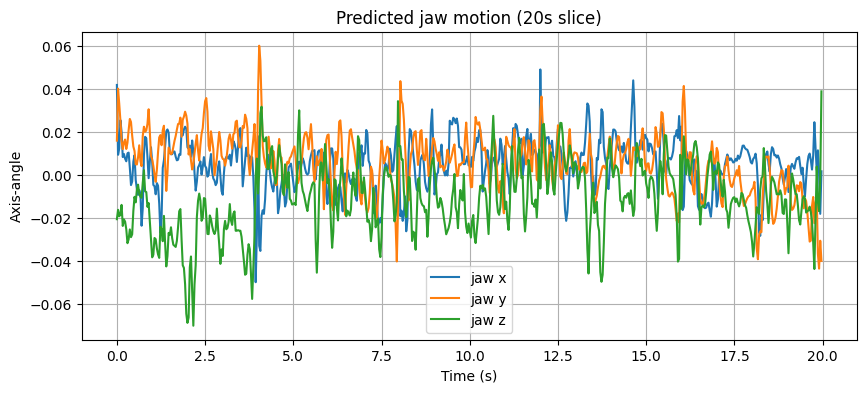

In [46]:
import matplotlib.pyplot as plt

t = np.arange(jaw_seq.shape[0]) / 30.0

plt.figure(figsize=(10,4))
plt.plot(t, jaw_seq[:,0], label="jaw x")
plt.plot(t, jaw_seq[:,1], label="jaw y")
plt.plot(t, jaw_seq[:,2], label="jaw z")
plt.xlabel("Time (s)")
plt.ylabel("Axis-angle")
plt.title("Predicted jaw motion (20s slice)")
plt.legend()
plt.grid(True)
plt.show()


In [47]:
def save_motion_npz(jaw, expr, out_path, fps=30):
    T = jaw.shape[0]
    poses = np.zeros((T, 55, 3), dtype=np.float32)
    poses[:, 22, :] = jaw  # jaw index

    betas = np.zeros((10,), dtype=np.float32)
    transl = np.zeros((T,3), dtype=np.float32)

    np.savez(
        out_path,
        poses=poses,
        expressions=expr.astype(np.float32),
        betas=betas,
        transl=transl,
        fps=np.int32(fps)
    )

OUT_NPZ = "motion_20s_pred.npz"
save_motion_npz(jaw_seq, expr_seq, OUT_NPZ)
OUT_NPZ


'motion_20s_pred.npz'